In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings

warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

In [6]:
train_df = pd.read_csv('/Users/tmasike/Documents/CISCO/soft_stuff/kaggle/Titanic/train.csv')
test_df = pd.read_csv('/Users/tmasike/Documents/CISCO/soft_stuff/kaggle/Titanic/test.csv')
test_df.head(5)
dfs = [train_df,test_df]
#train_df.info()

In [7]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [8]:
df_all = concat_df(train_df,test_df)
train_df.name = 'Training Set'
test_df.name = 'Test Set'
df_all.name = 'All Set'
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Missing values in Age are generally filled with median age, but using median age of the whole data set is not a good choice because it's not a very granular way to solve the issue. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481). It is also more logical to group ages by passenger classes instead of other features.

In [10]:
print('Number of Training Examples = {}'.format(train_df.shape[0]))
print('Number of Test Examples = {}\n'.format(test_df.shape[0]))
print('Training X Shape = {}'.format(train_df.shape))
print('Training y Shape = {}\n'.format(train_df['Survived'].shape[0]))
print('Test X Shape = {}'.format(test_df.shape))
print('Test y Shape = {}\n'.format(test_df.shape[0]))
print(train_df.columns)
print(test_df.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [11]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


From the Age correlation coefficient table above, you can see that the strongest correlation is with Pclass

In [12]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Pclass']

,Feature 1,Feature 2,Correlation Coefficient
4,Pclass,Pclass,1.000000
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
13,Pclass,Survived,0.338481
32,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
43,Pclass,Parch,0.018322


From the Pclass correlation table above it is apparent that there is a strong correlation between class and probability of surviving

In [13]:
#Survival rate of men
men = train_df[train_df["Sex"]=='male']
rate_men = 100*men["Survived"].sum()/len(men)

print("% of men who survived:", rate_men)
#print(train_df[train_df["Sex"]==1]["Survived"].sum())
#print(len(train_df[train_df["Sex"]==0]))

% of men who survived: 18.890814558058924


In [14]:
#Survival rate of women
women = train_df[train_df["Sex"]=='female']
rate_women = 100*women["Survived"].sum()/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 74.20382165605096


In [15]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


The medium age of first class is older than that of the other classes, which makes sense logically as older people tend to have more money than younger people. There's also a strong correlation of sex and survival and the data above expresses that

In [16]:
print(train_df.info())
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
735,736,0,3,"Williams, Mr. Leslie",male,28.5,0,0,54636,16.1000,NaN,S
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C


In [17]:
df_all[df_all['Embarked'].isnull()]


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


The number of unknown embarked entries is two, but they're on the same ticket so they know each other and boarded from the same place.

After googling "Icard, Miss. Amelie", we found that she embarked in Southampton so we can assume that the both of them embarked at the same place because they both used the exact same ticket.	

In [18]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')


In [19]:
df_all[df_all['Fare'].isnull()]


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


There is only one person with a missing Fare value. It's safe to assume that the fare amount is related to family size and class. The median value of a male, in third class with no family is a reasonable set of parameters to use to fill in the missing parameters

In [20]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [21]:
print(med_fare)

7.8542


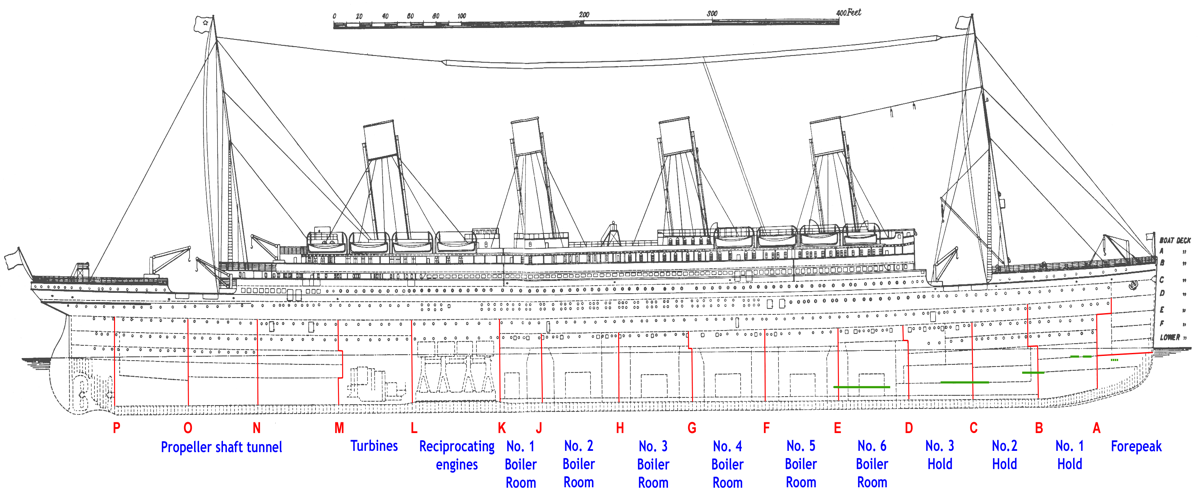

In [22]:
from PIL import Image
img = Image.open('titanic.png')
img = img.resize((1200, 500))
img

## **The Cabin feature is quite complex and deserves a deeper explanation, from the functions above a significant portion of the cabin feature values are missing and it cannot be ignored since its sensible to think that some cabins have a higher survival rate than others:**

- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
- A, B and C decks were only for 1st class passengers
- D and E decks were for all classes
- F and G decks were for both 2nd and 3rd class passengers
- From going A to G, distance to the staircase increases which might be a factor of survival

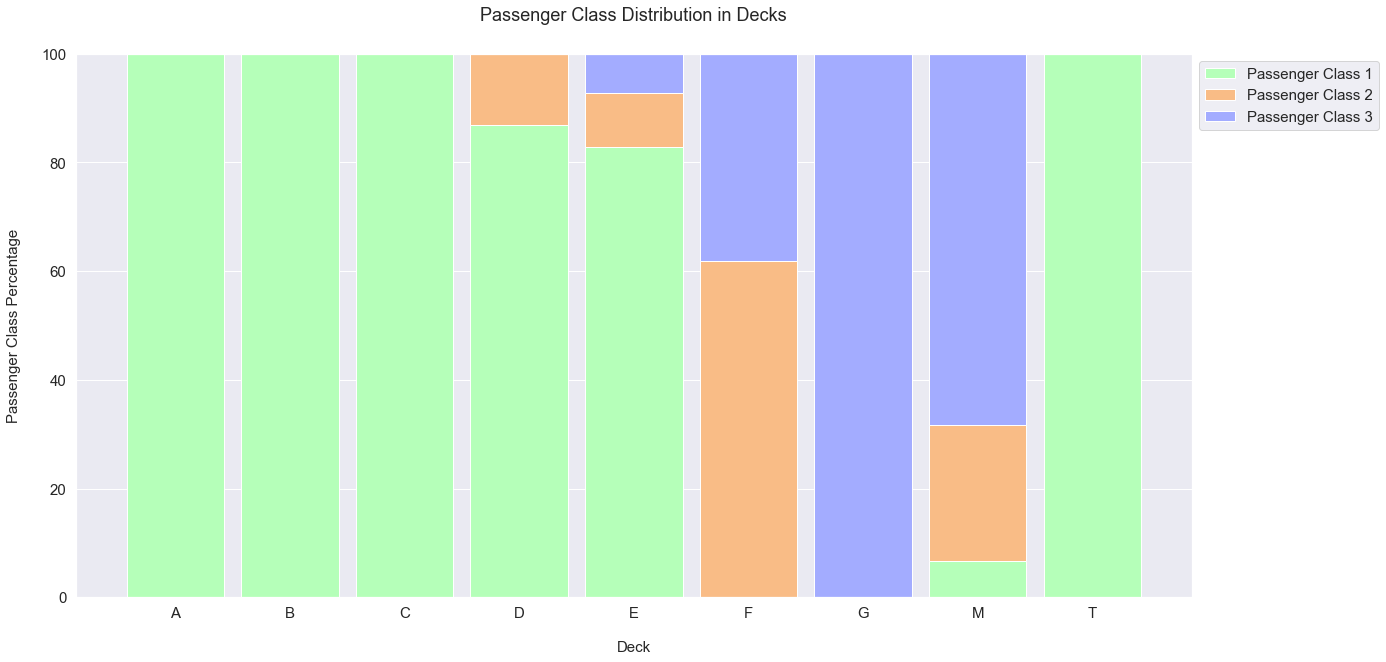

In [23]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck','Pclass']).count().drop(columns=['Survived','Sex','Age','SibSp','Parch','Fare','Embarked',
'Cabin','PassengerId','Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_pclass_dist(df):
     # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {},'B': {},'C': {},'D': {},'E':{},'F':{},'G':{},'M':{},'T':{}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1,4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):

    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A','B','C','D','E','F','G','M','T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20,10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()   

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)    



- ### 100% of A, B and C decks are 1st class passengers ###
- ### Deck D has 87% 1st class and 13% 2nd class passengers ###
- ### Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers ###
- ### Deck F has 62% 2nd class and 38% 3rd class passengers ###
- ### 100% of G deck are 3rd class passengers ###
- ### There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck ###
- ### Passengers labeled as M are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck so I decided to use M like a deck ###

In [24]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'


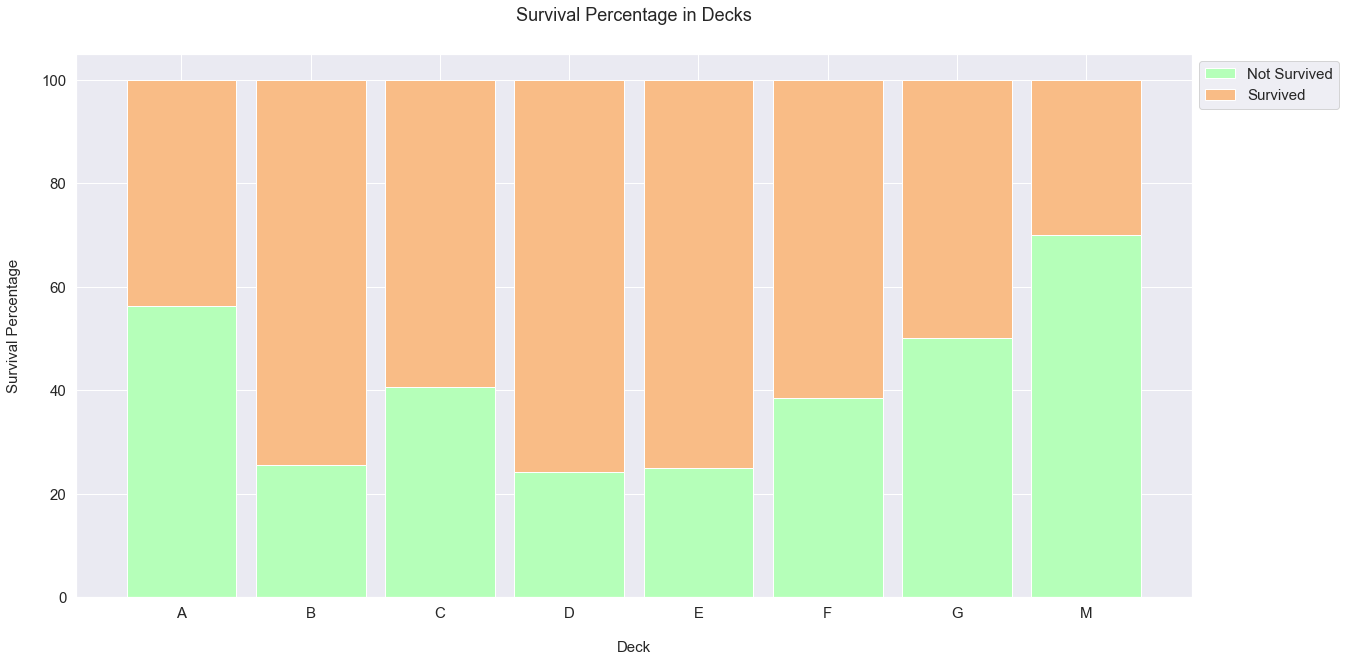

In [25]:
df_all_decks_survived = df_all.groupby(['Deck','Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):

    # Creating a dictionary for every survival count in every deck
    surv_counts =       {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]  

    for deck in decks:
        for survive in range(0,2):
            surv_counts[deck][survive] = df[deck][survive][0]

    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()         

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)                             

## **As expected, each and every deck has different survival rates and this information is very important. Deck B, C, D and E had the highest survival rates and, coincidentily, those decks are mostly occupied by 1st class passengers. M has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers.** 

## **To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion M (Missing Cabin values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as M is a reasonable way to handle the missing data. It is a unique group with shared characteristics. Deck feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.**

- ### A, B and C decks are labeled as ABC because all of them have only 1st class passengers
- ### D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
- ### F and G decks are labeled as FG because of the same reason above
- ### M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [26]:
# So now we are going to combine the similar classes

df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

## **After filling in the missing values of Age, Embarked, Fare and Deck there are no missing values left in either the training or test set and we drop the Cabin feature because the Deck feature will be used in it's place**

In [27]:
df_all.drop(['Cabin'],inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train,df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




In [28]:
df_train, df_test = divide_df(df_all)
dfs = [df_train,df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


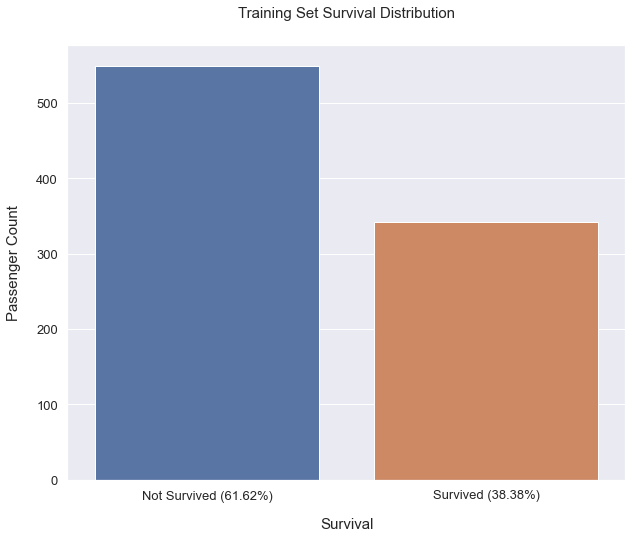

In [29]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

# **Correlations**

## There are features which are highly correlateed with each other and depend on each other, the highest correlation between features is 0.549500 in training set and 0.577147 in test set (between Fare and Class)

In [30]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)


In [31]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [32]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient']>0.1
df_test_corr_nd[corr]


,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


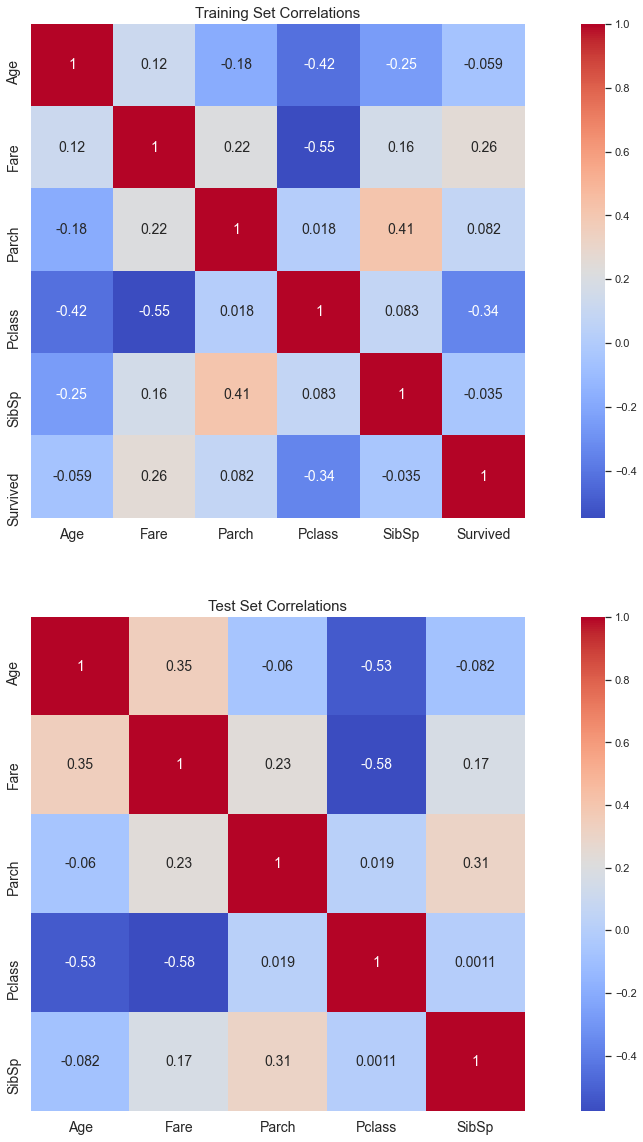

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

# Target distribution in features

## Continuous features

### Both of the continuous features (Age and Fare) have good split points and spikes for a decision tree to learn. An issue that may occur is that the training set is rough and bumpy whereas the test set is nice and smooth which could cause problems for ### when we model the the solution as it may not be able to generalise the test set like this

- ### Distribution of age shows that children younger than 15 have a higher survival rate than any of thee otheeer age groups
- ### In distribution of Fare feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

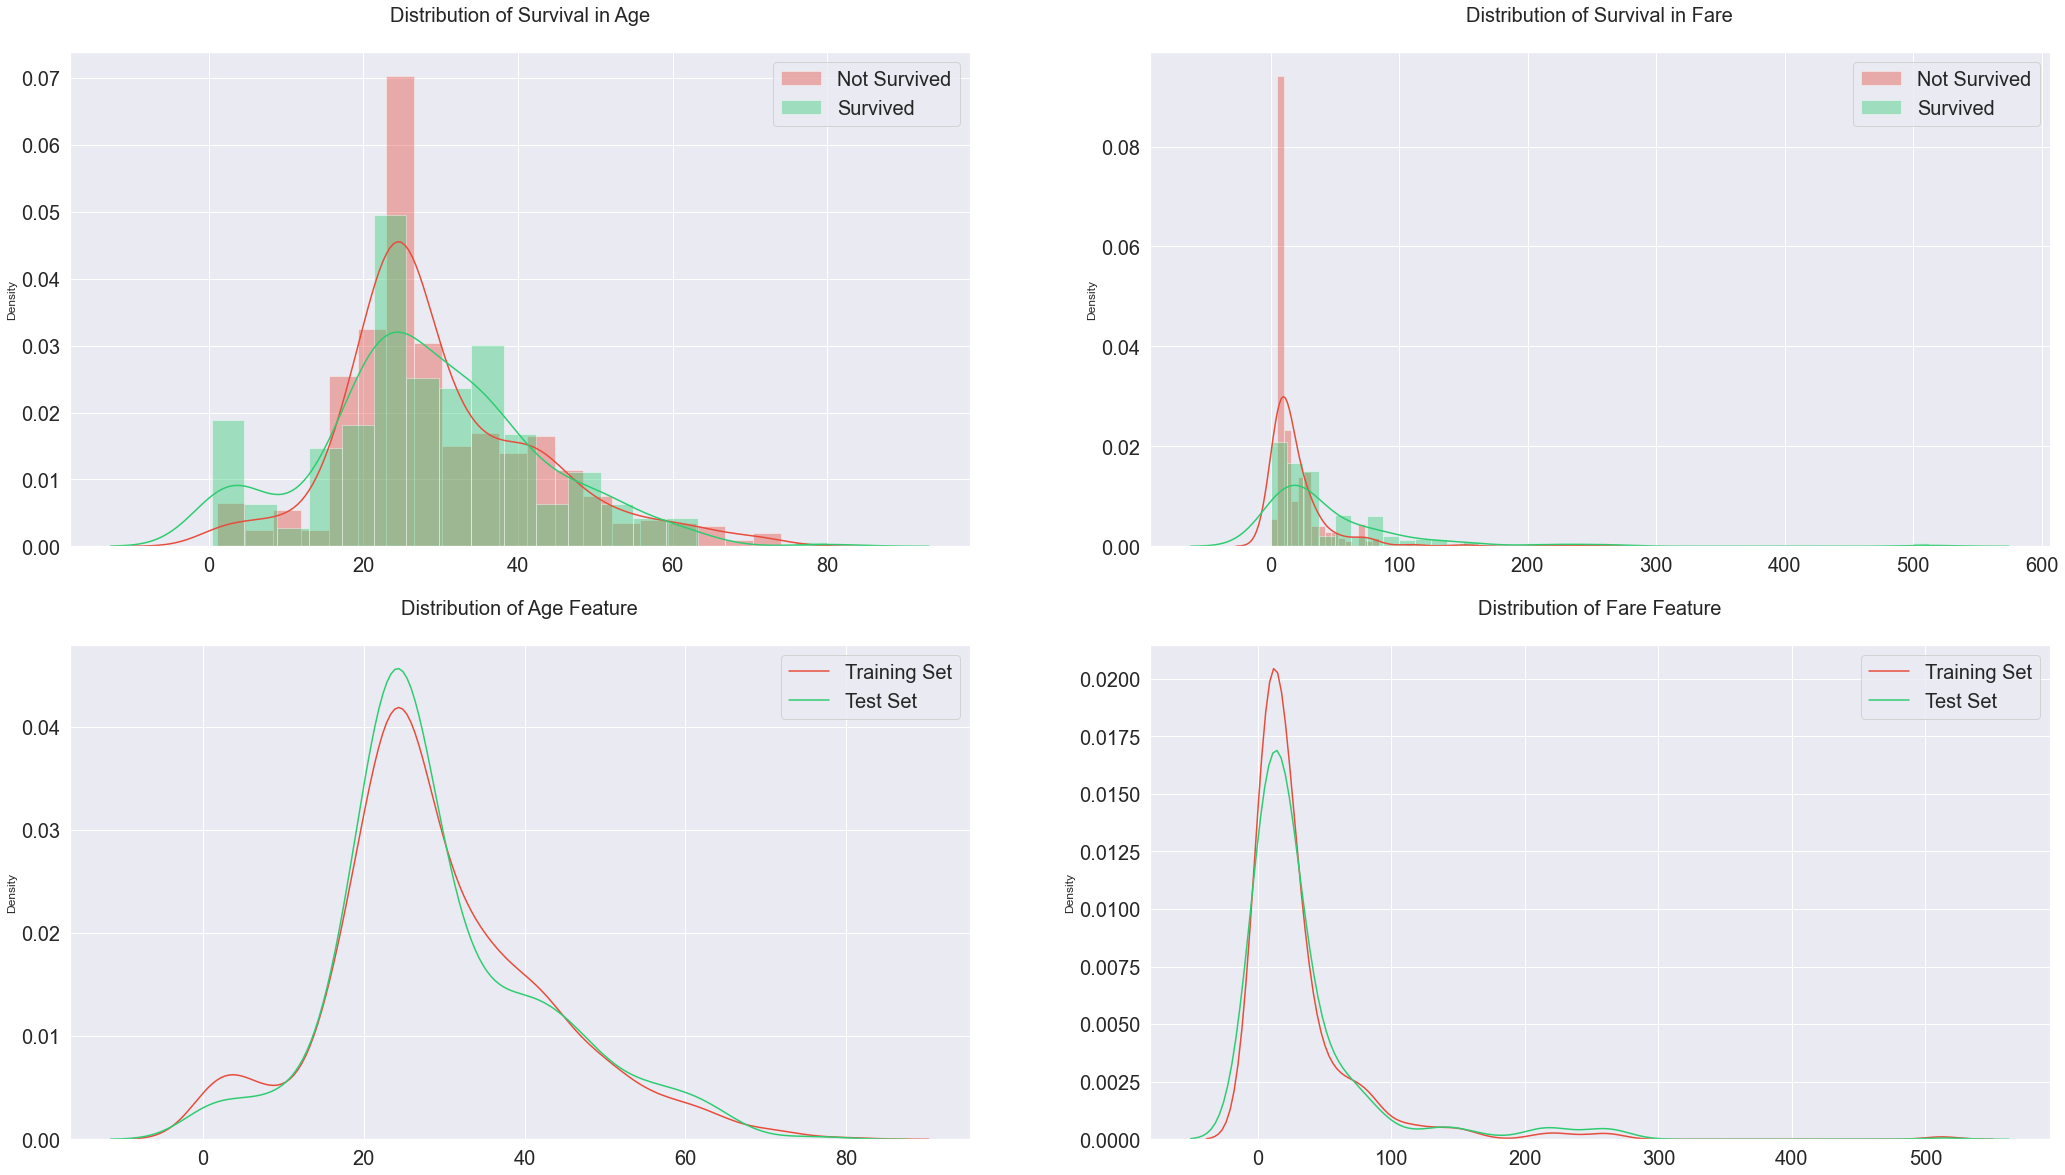

In [34]:
cont_features = ['Age','Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

## Categorical Features

### Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or not. Best category features are Pclass and Sex because they have the most homogenous distributions

- ### Passengers boarded from Southampton has a lower survival rate unlike other ports. More than half of the passengers boarded from Cherbourg had survived. This observation could be related to Pclass feature
- ### Parch and SibSp features show that passengers with only one family member has a higher survival rate

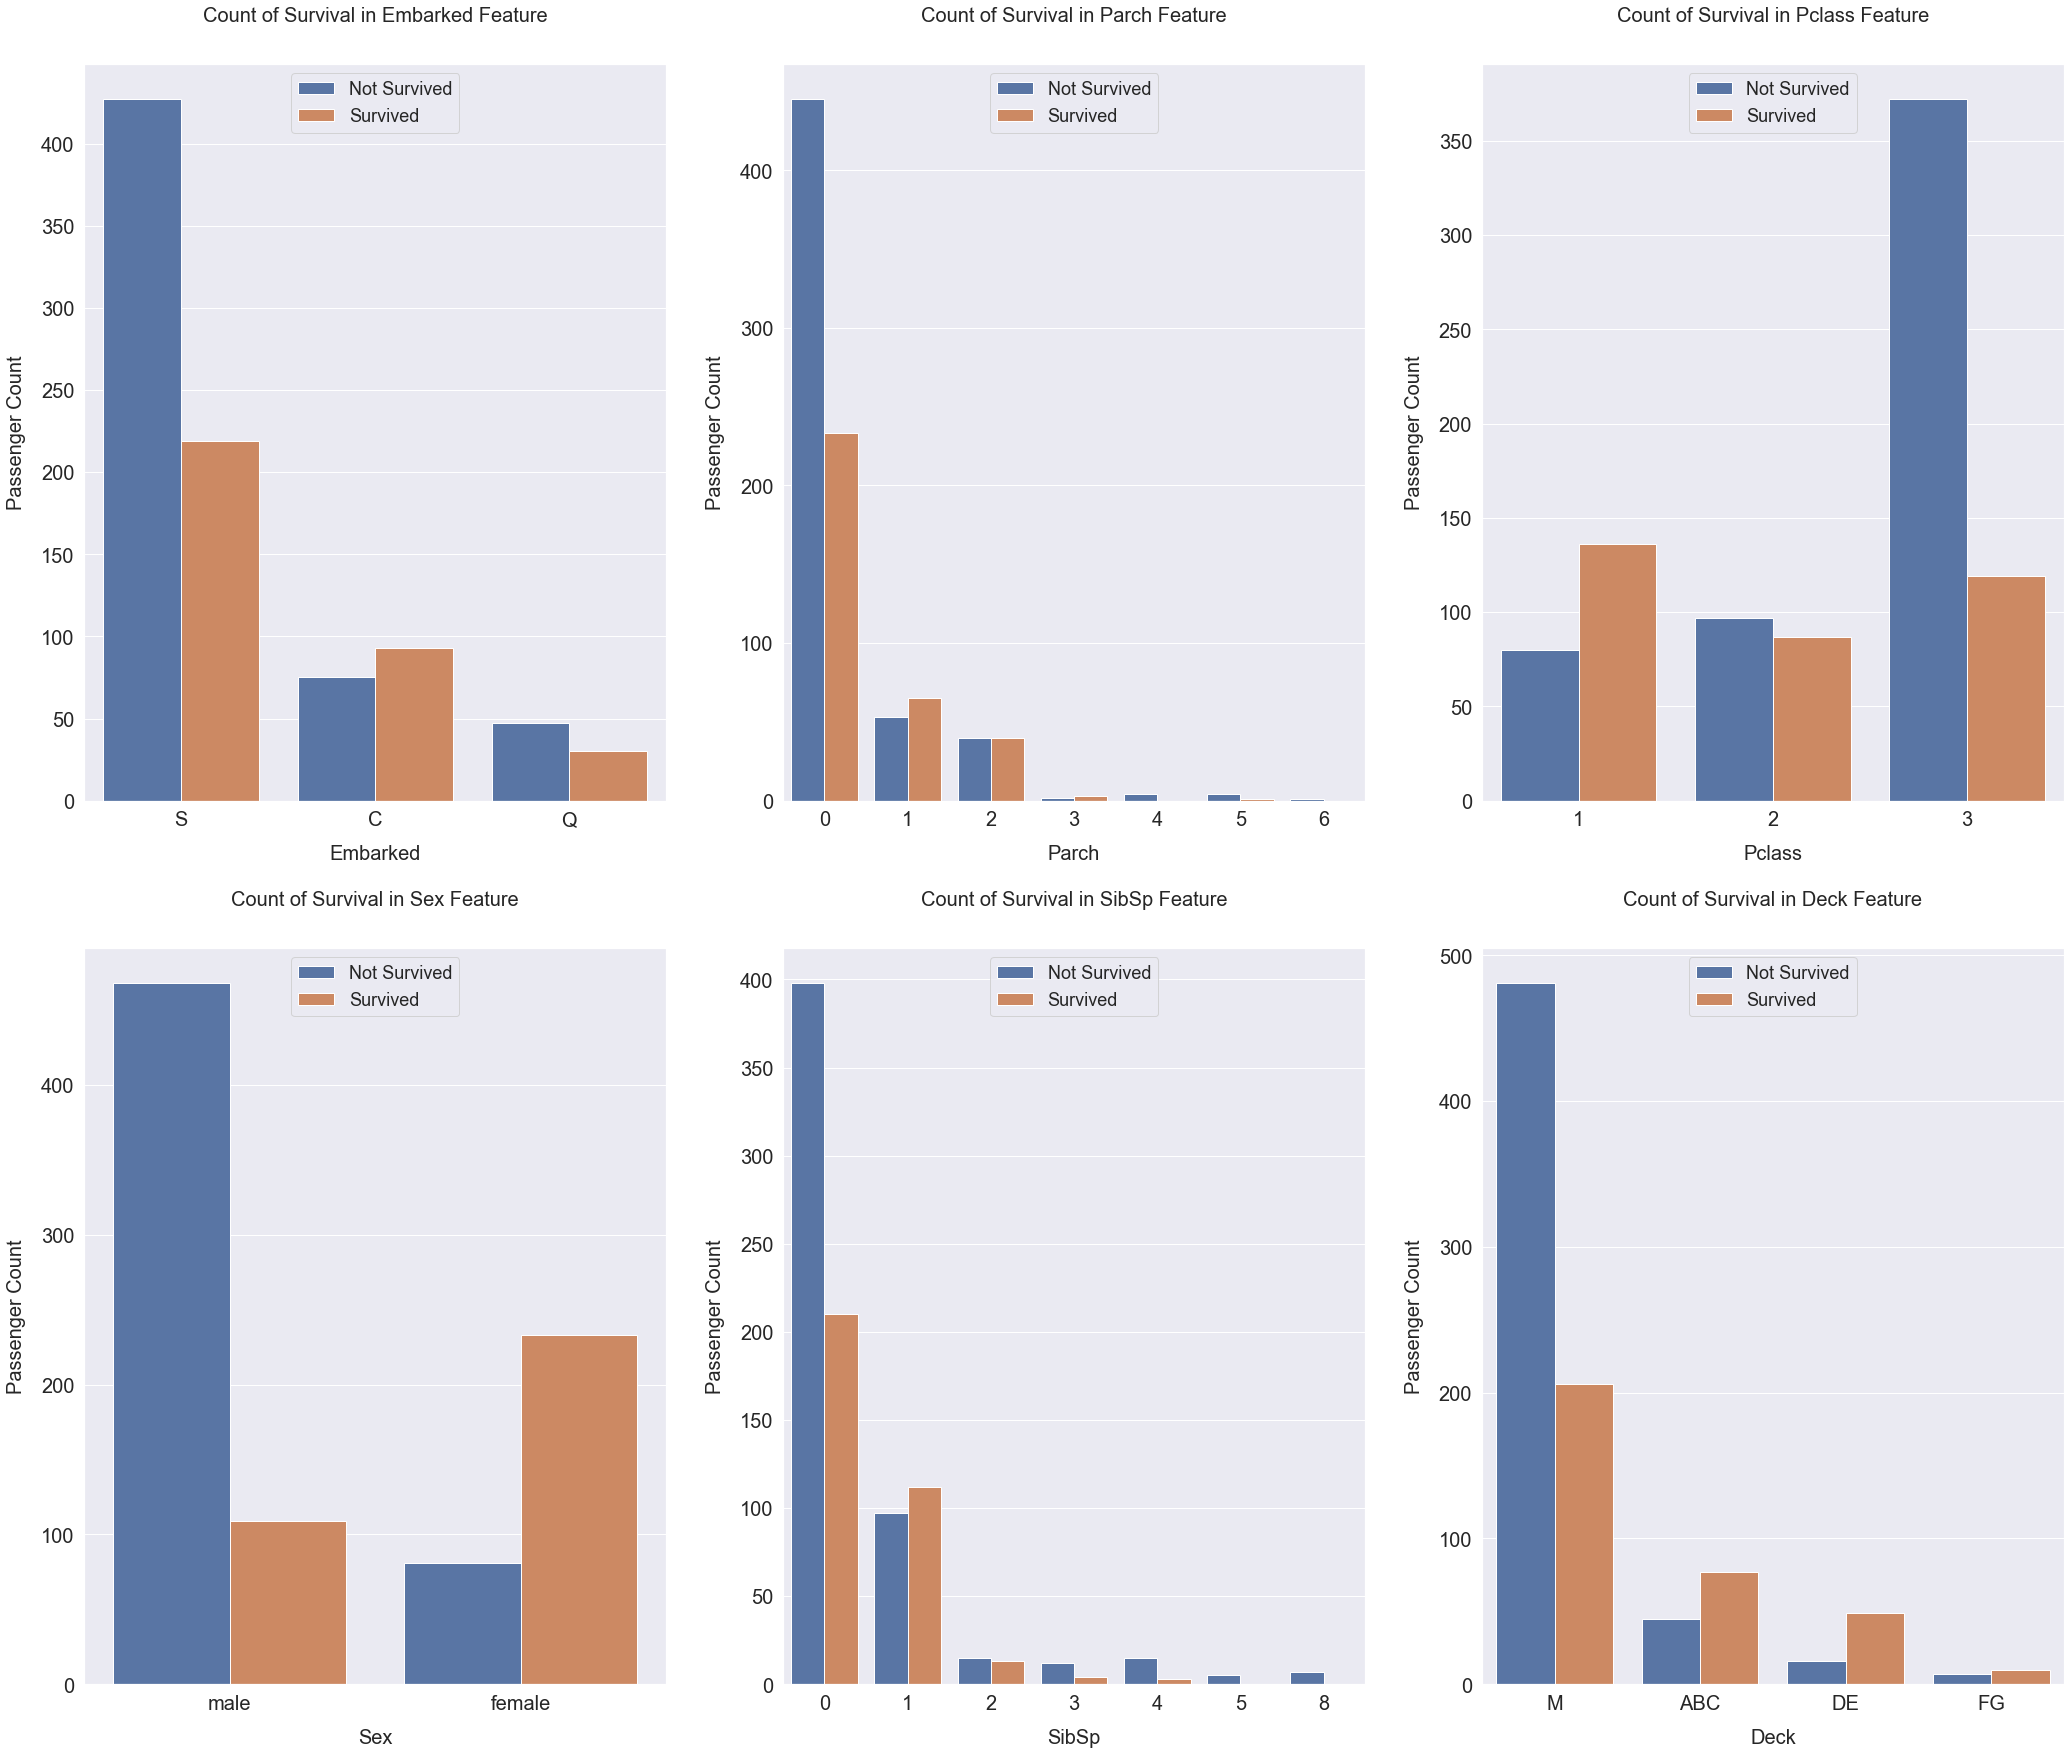

In [35]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

## Conclusion

### Most features correlate with each other. And this special relationship can be used to create new features. Target encoding can be very useful because of the high correlations with the Survived feature.

### Singularities are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot the singularities.

### Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features

### We created a new feature called Deck and dropped Cabin feature in the EDA part

In [36]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# **Feature Engineering**

## **Binning continuous features**

### **Fare**

### Fare is a positively skewed and survival rate is extremely high on the right end. So 13 quantile based bins are used for the Fare feature. Even though the bins are a lot, the inclusion of extra bins do provide a decent amount of info gain. The groups at the left side of the graph, i.e. the ones who paid the least, have the lowest survival rate and the groups on the right, i.e. the rich people, have the highest survival rate. This high survival rate was not easily seen in the distribution graph. There is also an unusual group **[15.742,23.25]** in the middle with the high survival rate that is captured in this process



In [37]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

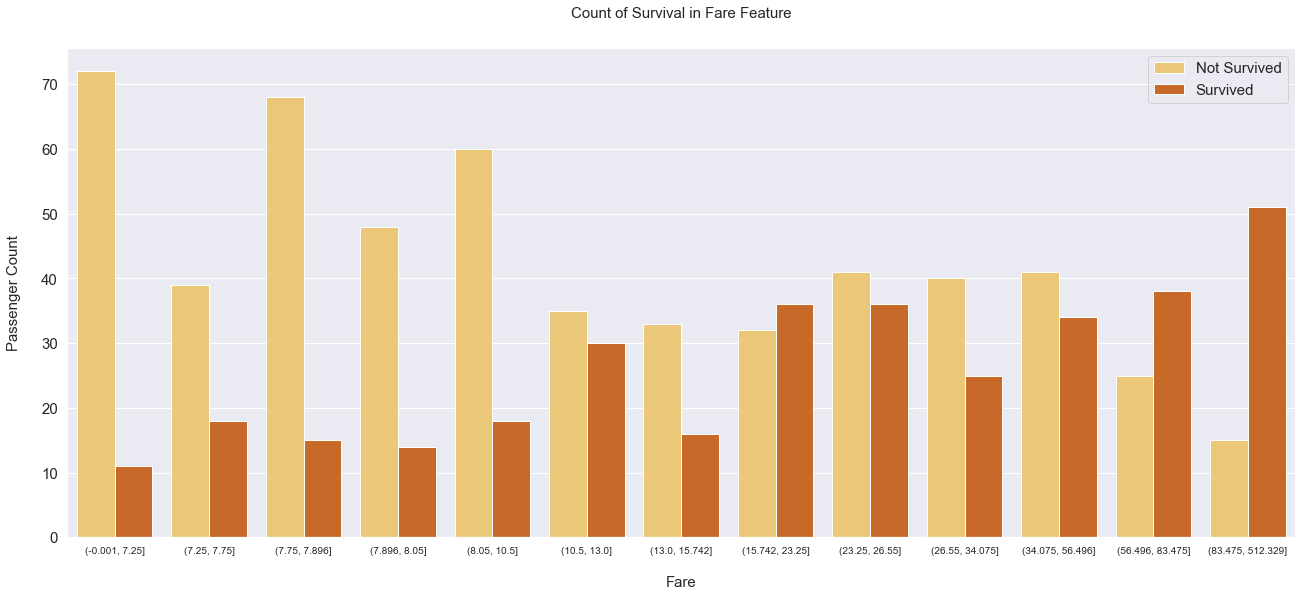

In [38]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all,palette='YlOrBr')

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

## Age

### Age feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for Age. The first bin has the highest survival ratee and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **[34.00,40.00]**

In [39]:
df_all['Age'] = pd.qcut(df_all['Age'],10)

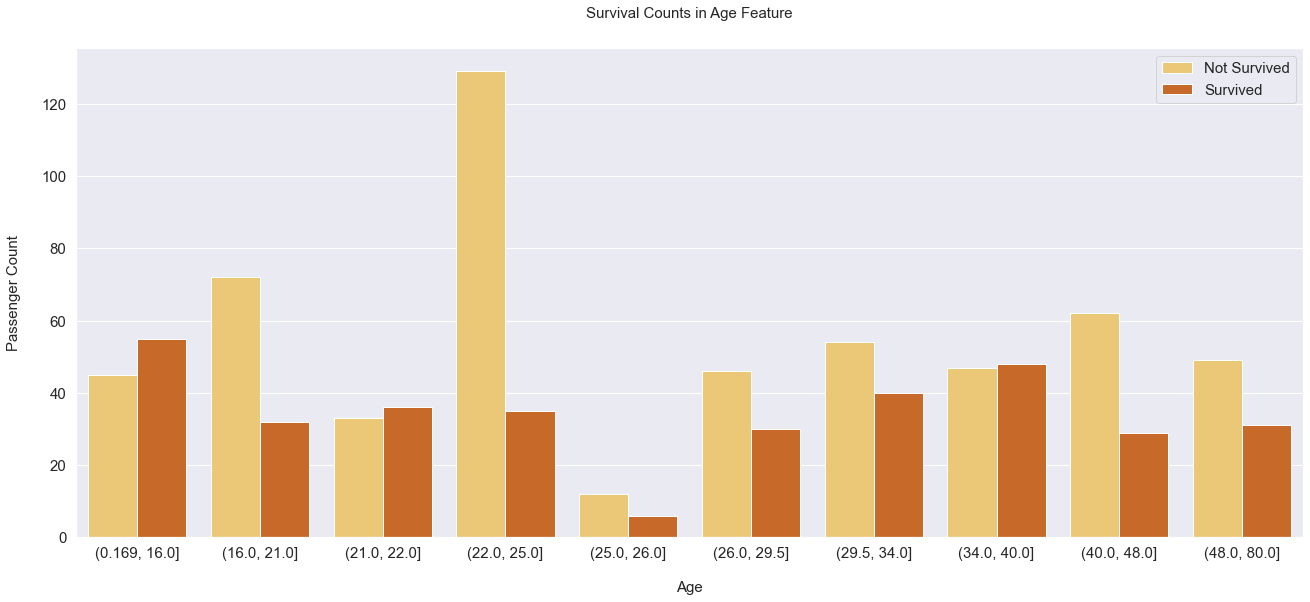

In [40]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all,palette='YlOrBr')

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## Frequency Encoding

### Family size is created by adding SibSp, Parch and 1. The 1 is to add the current passenger. Family size is a predictor of survival because different values have different survival rates.

- ### Family size **1** are labeled as **Alone**
- ### Family size with **2**,**3** and **4** are labeled as **Small**
- ### Family size with **5** and **6** are labeled as **Medium**
- ### Family size with **7**,**8** and **11** are labeled as **Large**

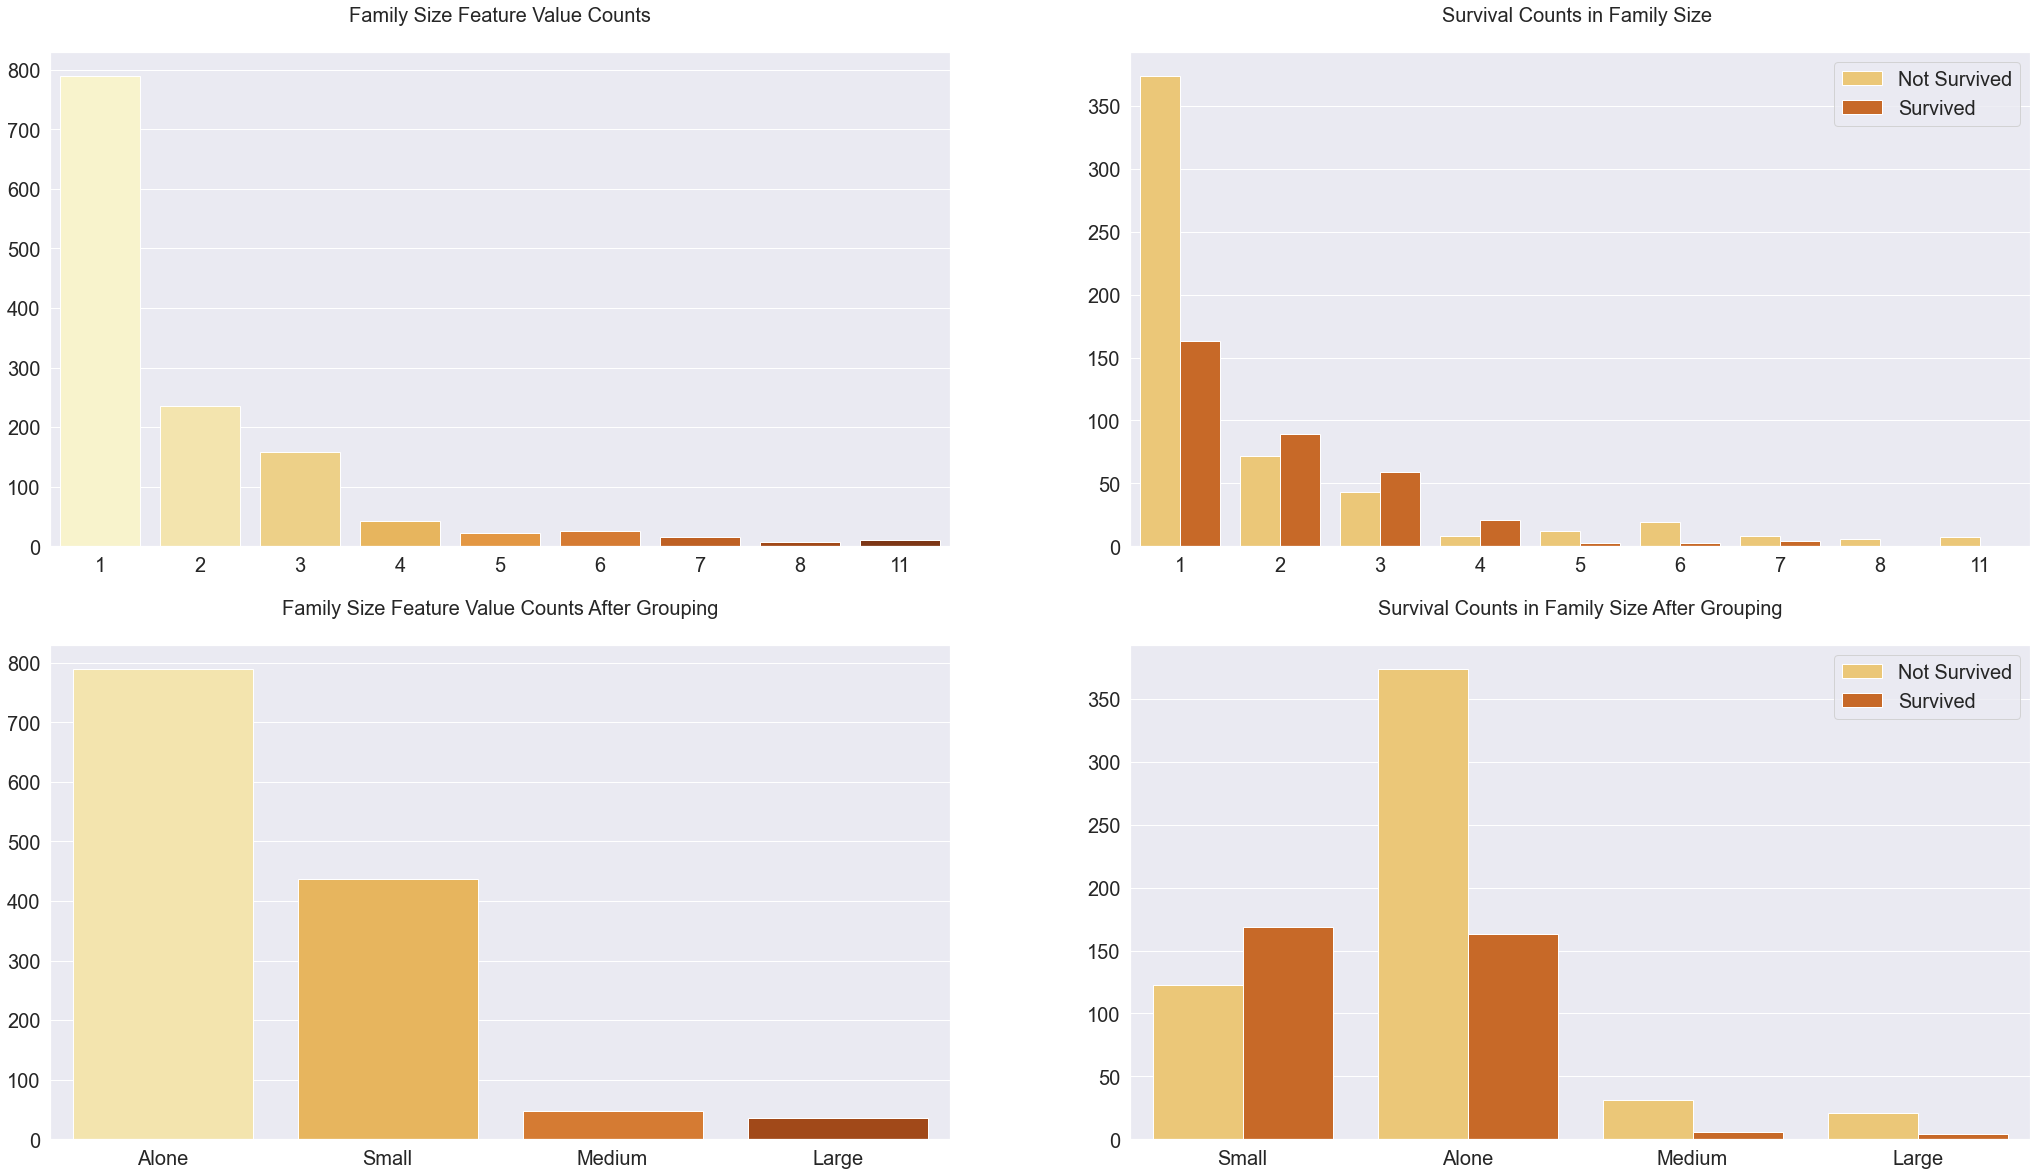

In [41]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0],palette='YlOrBr')
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1],palette='YlOrBr')

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0],palette='YlOrBr')
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1],palette='YlOrBr')

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

### There are way too many tickets to analyze on their own so we are going to group them by their frequencies. This feature is **different from family** because you can be in a group with multiple families or you can be in a group with family + maid + nanny etc. They weren't seen as family but they were counted on the ticket.

### **Why not grouping tickets by their prefixes?** If prefixes in Ticket feature has any meaning, then they are already encompassed within Pclasss or Embarked since that would be the only logical information which can be derived from the Ticket feature

In [42]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

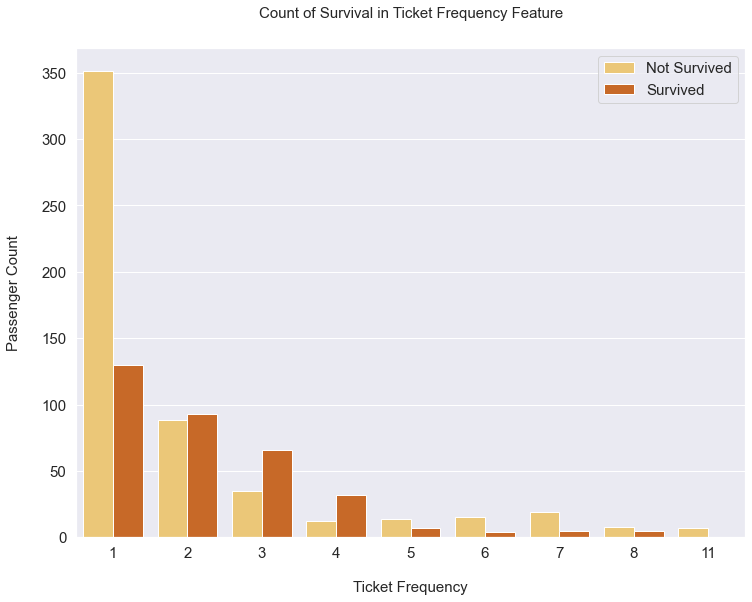

In [52]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all, palette='YlOrBr')

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

## According to the graph above, groups with 2,3 and 4 members had a higher survival rate. Passengers who travel alone have the lowest survival rate. After 4 group members, survival rate decreases drastically. This pattern is very similar to Family_Size feature but there are minor differences. Ticket_Frequency values are not grouped like Family_Size because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

## **Title & Is Married**

### Title is what happens when you extract the prefix before the Name feature. By looking at graph below, you can see that there are many titles that occur very few times, some of which are not correct and need to be replaced by another value. Titles such as **Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona** are replaced with **Miss/Mrs/Ms** since all of them are female. **Dr, Col, Major, Jonkheer, Capt, Sir, Don, Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26** (I did not know that). They have the highest survival rate among all males.

### Is_Married is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [53]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

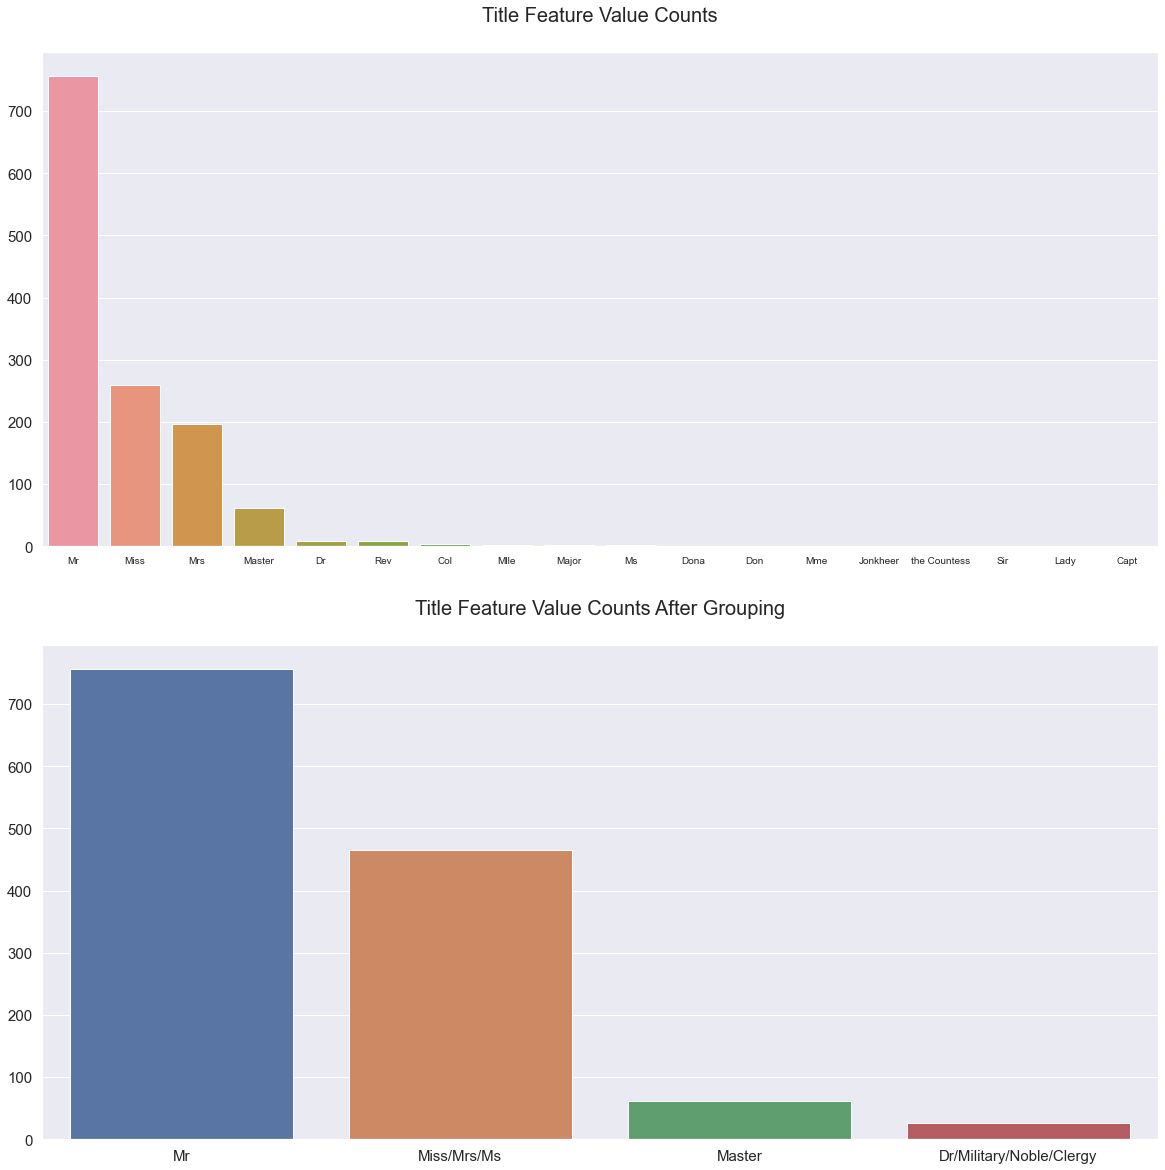

In [54]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## Target Encoding

### extract_surname function is used for extracting surnames of passengeers from the Name feature. The Family featur is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [55]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

### Family_Survival_Rate is calculated from families in training set since there is no Survived feature in test set. A list of family names that are occuring in both training and test set (non_unique_families), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature.

### An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

### Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created with the same method. Ticket_Survival_Rate and Family_Survival_Rate are averaged and become Survival_Rate, and Ticket_Survival_Rate_NA and Family_Survival_Rate_NA are also averaged and become Survival_Rate_NA.

In [57]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [58]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [59]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2  

## **Feature Transformation**

### **Label Encoding Non-numerical features**

### Embarked, Sex, Deck, Title and Family_Size_Grouped are object type, and Age and Fare features are category type. They are converted to numerical type with LabelEncoder. LabelEncoder basically labels the classes from **0** to **n**. This process is necessary to learn from those features.

In [60]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

### **One-Hot Encoding the Categorical Features**
### The categorical features (Pclass, Sex, Deck, Embarked, Title) are converted to one-hot encoded features with OneHotEncoder. Age and Fare features are not converted because they are ordinal unlike the previous ones.

In [61]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

## **Conclusion**
### Age and Fare features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. Family_Size is created by adding Parch and SibSp features and 1. Ticket_Frequency is created by counting the occurence of Ticket values.

### Name feature is very useful. First, Title and Is_Married features are created from the title prefix in the names. Second, Family_Survival_Rate and Family_Survival_Rate_NA features are created by target encoding the surname of the passengers. Ticket_Survival_Rate is created by target encoding the Ticket feature. Survival_Rate feature is created by averaging the Family_Survival_Rate and Ticket_Survival_Rate features.

### Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created 5 new features (Family_Size, Title, Is_Married, Survival_Rate and Survival_Rate_NA) and dropped the useless features after encoding.

In [62]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


# **Model**

In [64]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


### **Random Forest**

### Created 2 RandomForestClassifier's. One of them is a single model and the other is for k-fold cross validation.

### The highest accuracy of the single_best_model is 0.82775 in public leaderboard. However, it doesn't perform better in k-fold cross validation. It is a good model to start experimenting and hyperparameter tuning.

### The highest accuracy of leaderboard_model is 0.83732 in public leaderboard with 5-fold cross validation. This model is created for leaderboard score and it is tuned to overfit slightly. It is designed to overfit because the estimated probabilities of X_test in every fold are going to be divided by N (fold count). If this model is used as a single model, it would struggle to predict lots of samples correctly.

### Which model should I use?

### - leaderboard_model overfits to test set so it's not suggested to use models like this in real life projects.
### - single_best_model is a good model to start experimenting and learning about decision trees.

In [69]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=0,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=0,
                                           n_jobs=-1,
                                           verbose=1) 

### StratifiedKFold is used for stratifying the target variable. The folds are made by preserving the percentage of samples for each class in target variable (Survived).

In [70]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 1 OOB Score: 0.8567415730337079

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 3 OOB Score: 0.8499298737727911

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 4 OOB Score: 0.8373071528751753

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 5 OOB Score: 0.8274894810659187

Average OOB Score: 0.8431575712687331


<AxesSubplot:xlabel='Survived', ylabel='Sex'>

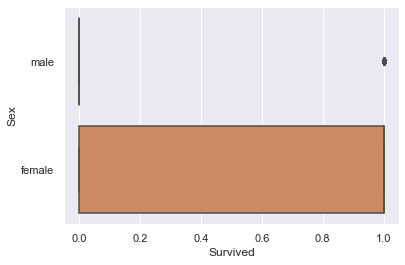

In [43]:
sns.boxplot(x='Survived',y='Sex',data=train_df)

## **Feature Importance**

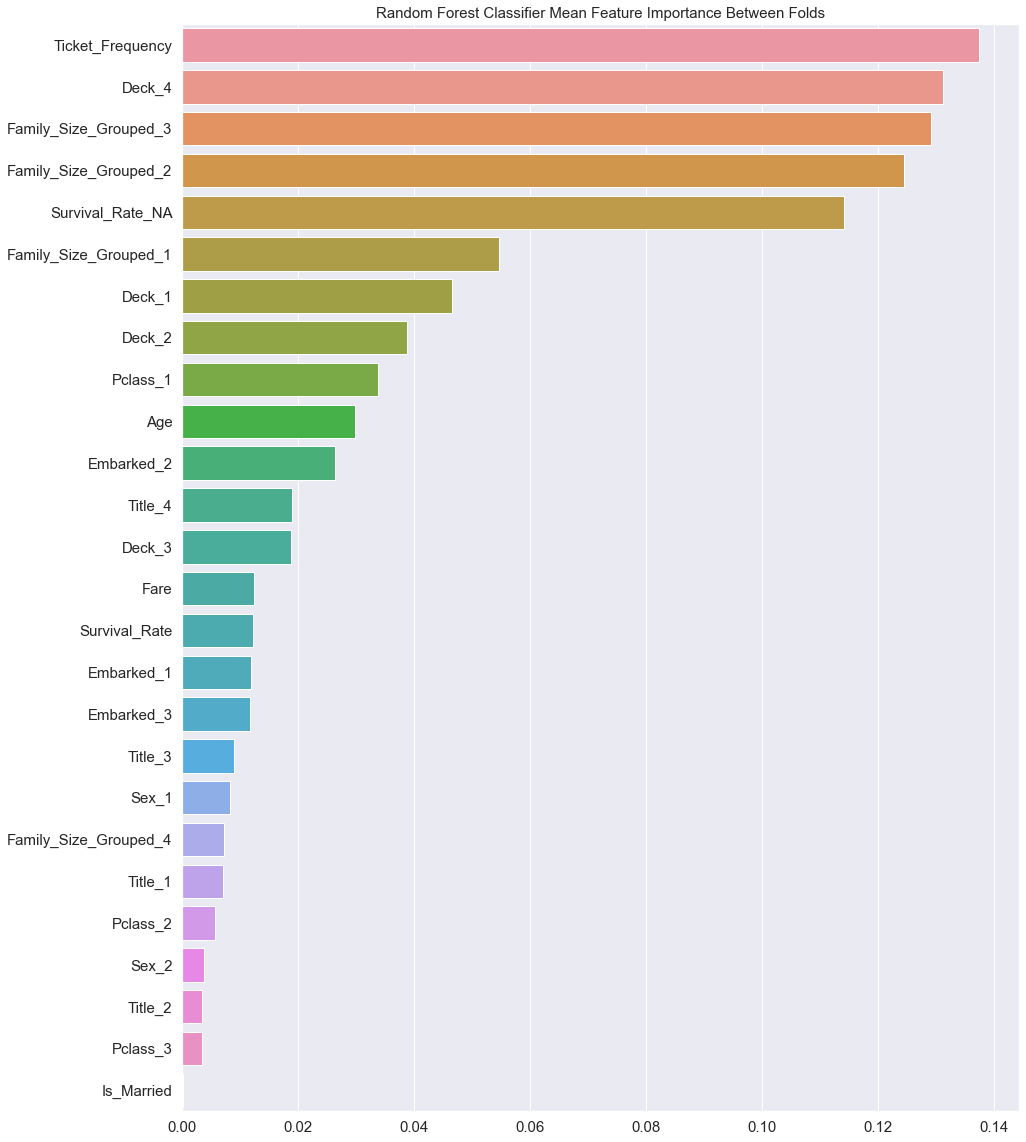

In [71]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

## **ROC Curve**

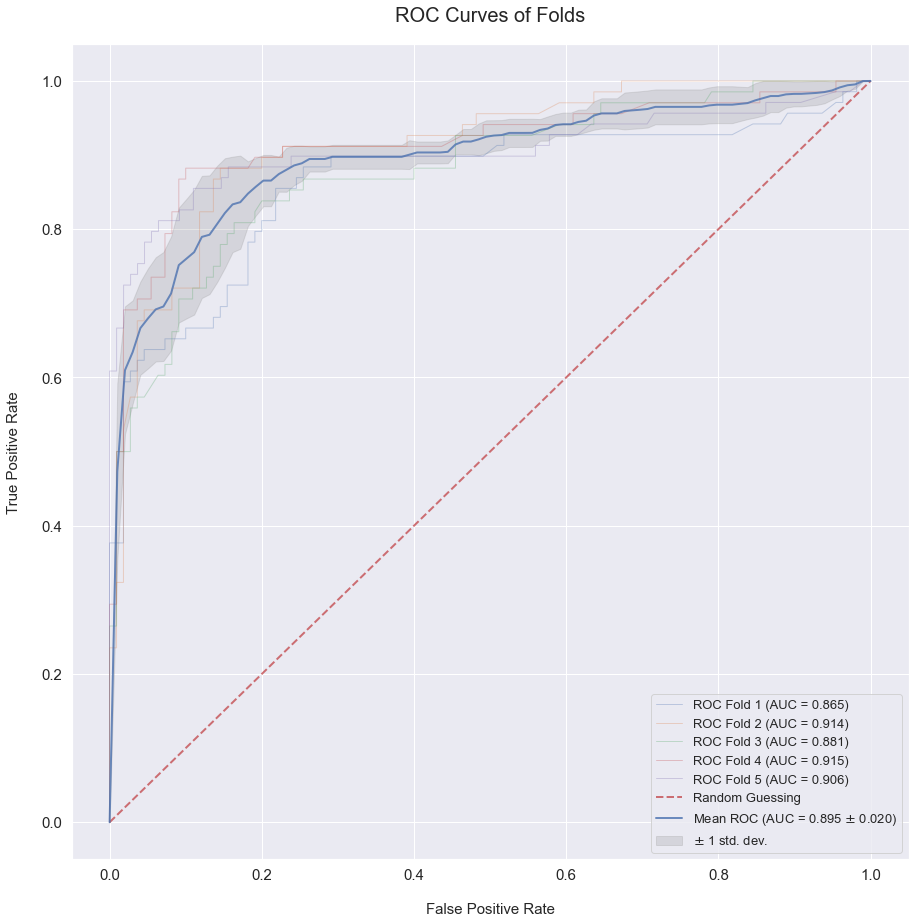

In [72]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

## **Submission**

In [73]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


# **EDA**

In [44]:
train_df["Survived"].value_counts(normalize=True)# How many passengers survived?

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [45]:
#We are now defining a function to draw a stacked bar graph
def bar_chart_stacked(dataset,feature,stacked=True):
    survived=train_df[train_df["Survived"]==1][feature].value_counts()
    dead=train_df[train_df["Survived"]==0][feature].value_counts()
    df_survived_dead=pd.DataFrame([survived,dead])
    df_survived_dead.index=["Survived","Died"]
    df_survived_dead.plot(kind="bar",stacked=stacked,figsize=(10,7))

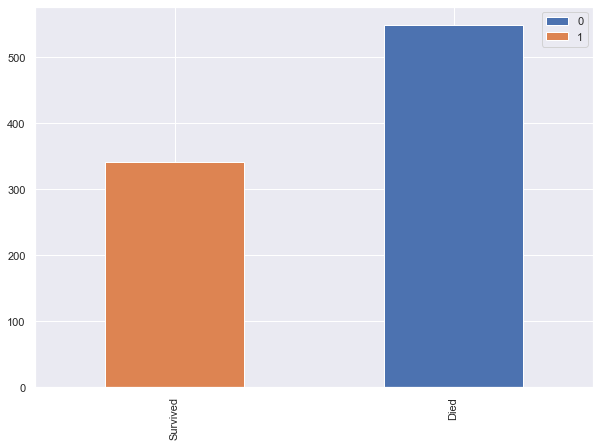

In [46]:
bar_chart_stacked(train_df,"Survived")

### **As you can see, the majority (62%) of people on the Titanic perished unfortunately. May their souls rest in peace. This, however, creates a dataset which is imbalanced**

In [47]:
train_df["Sex"].value_counts().to_frame() #passenger count on gender column. the .to_frame() function is to 
                                          #change a series to dataframe

,Sex
male,577
female,314


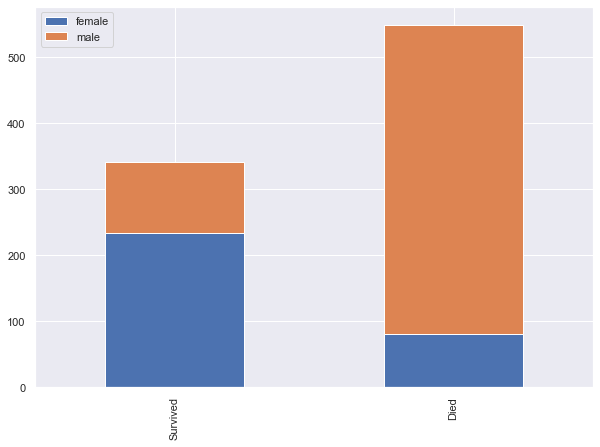

In [48]:
bar_chart_stacked(train_df,"Sex")#Compares the survivors and the not so lucky on a stacked bar graph

### **The majority of the survivors women even though most of the people on the Titanic were men. The main thing to note is that the survival rate of women is 4 times higher than that of men. Why that could be, as seen in the historic movie, is that women and children were prioritised when the ship was sinking and the men were to be saved last. But as the ship sank, the men did not have enough time to save themselves.**

In [49]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### **Since I found the dataset with the Pclass already separated, I've embarked on a quick endeavour to put them together in a separate column in a dummy df variable just for shits and giggles and the practice of course.**

In [50]:
pclass1 = train_df["Pclass_1"].astype(int)*1
pclass1()

KeyError: 'Pclass_1'

In [ ]:
pclass2 = train_df["Pclass_2"].astype(int)*2
pclass2

PassengerId
1      0
2      0
3      0
4      0
5      0
      ..
788    0
789    0
790    0
791    0
792    2
Name: Pclass_2, Length: 792, dtype: int64

In [ ]:
pclass3 = train_df["Pclass_3"].astype(int)*3
pclass3

PassengerId
1      3
2      0
3      3
4      0
5      3
      ..
788    3
789    3
790    0
791    3
792    0
Name: Pclass_3, Length: 792, dtype: int64

In [ ]:
pclass = pclass1 +pclass2+pclass3
pclass

PassengerId
1      3
2      1
3      3
4      1
5      3
      ..
788    3
789    3
790    1
791    3
792    2
Length: 792, dtype: int64

In [ ]:
train_df2 = train_df
train_df2.head()

,Unnamed: 0,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3
PassengerId,,,,,,,,,,,,,,,,
1,0,0,1,0.2750,0.014151,0,0,1,0.1,1,0,0,0,0,0,1
2,1,1,0,0.4750,0.139136,1,0,0,0.1,1,0,0,0,1,0,0
3,2,1,0,0.3250,0.015469,0,0,1,0.0,0,0,0,1,0,0,1
4,3,1,0,0.4375,0.103644,1,0,0,0.1,1,0,0,0,0,0,1
5,4,0,1,0.4375,0.015713,0,0,1,0.0,1,0,0,0,0,0,1


In [ ]:
#train_df2["Pclass"] = pclass
train_df2.head(20)

,Unnamed: 0,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3
0,0,1,0,1,0.2750,0.014151,0,0,1,0.1,1,0,0,0,0,0,1
1,1,2,1,0,0.4750,0.139136,1,0,0,0.1,1,0,0,0,1,0,0
2,2,3,1,0,0.3250,0.015469,0,0,1,0.0,0,0,0,1,0,0,1
3,3,4,1,0,0.4375,0.103644,1,0,0,0.1,1,0,0,0,0,0,1
4,4,5,0,1,0.4375,0.015713,0,0,1,0.0,1,0,0,0,0,0,1
5,5,6,0,1,0.3500,0.016510,0,0,1,0.0,1,0,0,0,0,1,0
6,6,7,0,1,0.6750,0.101229,1,0,0,0.0,1,0,0,0,0,0,1
7,7,8,0,1,0.0250,0.041136,0,0,1,0.4,0,0,1,0,0,0,1
8,8,9,1,0,0.3375,0.021731,0,0,1,0.2,1,0,0,0,0,0,1
9,9,10,1,0,0.1750,0.058694,0,1,0,0.1,1,0,0,0,1,0,0


In [ ]:
#train_df2.drop("Pclass_1",",axis=1,inplace=True)
train_df2.head()


,Unnamed: 0,Survived,Sex,Age,Fare,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3,Pclass
PassengerId,,,,,,,,,,,,,,,,
1,0,0,1,0.2750,0.014151,0,1,0.1,1,0,0,0,0,0,1,3
2,1,1,0,0.4750,0.139136,0,0,0.1,1,0,0,0,1,0,0,1
3,2,1,0,0.3250,0.015469,0,1,0.0,0,0,0,1,0,0,1,3
4,3,1,0,0.4375,0.103644,0,0,0.1,1,0,0,0,0,0,1,1
5,4,0,1,0.4375,0.015713,0,1,0.0,1,0,0,0,0,0,1,3


In [ ]:
#train_df2.drop("Pclass_2",axis=1,inplace=True)
#train_df2.drop("Pclass_3",axis=1,inplace=True)
train_df.head()

,Unnamed: 0,Survived,Sex,Age,Fare,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3,Pclass
PassengerId,,,,,,,,,,,,,,
1,0,0,1,0.2750,0.014151,0.1,1,0,0,0,0,0,1,3
2,1,1,0,0.4750,0.139136,0.1,1,0,0,0,1,0,0,1
3,2,1,0,0.3250,0.015469,0.0,0,0,0,1,0,0,1,3
4,3,1,0,0.4375,0.103644,0.1,1,0,0,0,0,0,1,1
5,4,0,1,0.4375,0.015713,0.0,1,0,0,0,0,0,1,3


In [ ]:
train_df2.head()

,Unnamed: 0,Survived,Sex,Age,Fare,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3,Pclass
PassengerId,,,,,,,,,,,,,,
1,0,0,1,0.2750,0.014151,0.1,1,0,0,0,0,0,1,3
2,1,1,0,0.4750,0.139136,0.1,1,0,0,0,1,0,0,1
3,2,1,0,0.3250,0.015469,0.0,0,0,0,1,0,0,1,3
4,3,1,0,0.4375,0.103644,0.1,1,0,0,0,0,0,1,1
5,4,0,1,0.4375,0.015713,0.0,1,0,0,0,0,0,1,3


In [ ]:
train_df.head()

,Unnamed: 0,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3
0,0,1,0,1,0.2750,0.014151,0,0,1,0.1,1,0,0,0,0,0,1
1,1,2,1,0,0.4750,0.139136,1,0,0,0.1,1,0,0,0,1,0,0
2,2,3,1,0,0.3250,0.015469,0,0,1,0.0,0,0,0,1,0,0,1
3,3,4,1,0,0.4375,0.103644,1,0,0,0.1,1,0,0,0,0,0,1
4,4,5,0,1,0.4375,0.015713,0,0,1,0.0,1,0,0,0,0,0,1


% of 1st class patreons who survived: 61.6580310880829


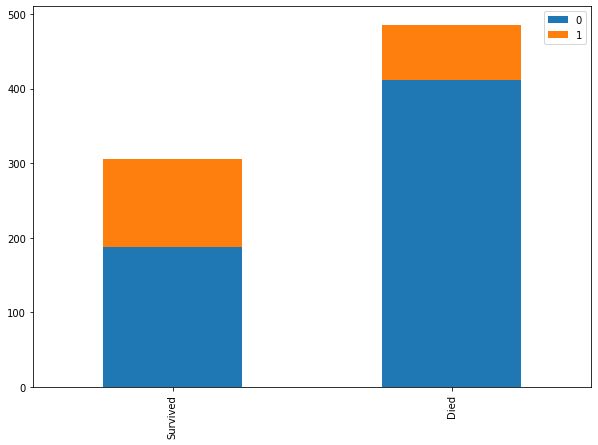

In [ ]:
bar_chart_stacked(train_df,"Pclass_1")

class1 = train_df[train_df["Pclass_1"]==1]
rate_class1 = 100*class1["Survived"].sum()/class1["Pclass_1"].sum()m()

#print("% of 1st class patreons who survived:", rate_class1)

% of 2nd class patreons who survived: 48.484848484848484


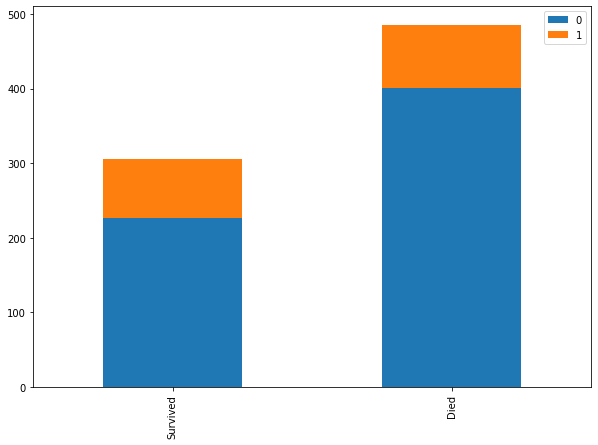

In [ ]:
bar_chart_stacked(train_df,"Pclass_2")

class2 = train_df[train_df["Pclass_2"]==1]
rate_class2 = 100*class2["Survived"].sum()/class2["Pclass_2"].sum()

print("% of 2nd class patreons who survived:", rate_class2)

% of 3rd class patreons who survived: 24.65437788018433


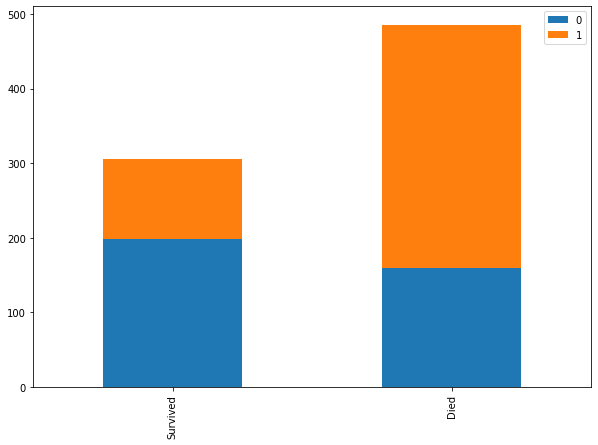

In [ ]:
bar_chart_stacked(train_df,"Pclass_3")

class3 = train_df[train_df["Pclass_3"]==1]
rate_class3 = 100*class3["Survived"].sum()/class3["Pclass_3"].sum()

print("% of 3rd class patreons who survived:", rate_class3)

In [ ]:
#bar_chart_stacked(train_df2,"Pclass")
train_df2.head(20)

,Unnamed: 0,Survived,Sex,Age,Fare,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3,Pclass
PassengerId,,,,,,,,,,,,,,
1,0,0,1,0.2750,0.014151,0.1,1,0,0,0,0,0,1,3
2,1,1,0,0.4750,0.139136,0.1,1,0,0,0,1,0,0,1
3,2,1,0,0.3250,0.015469,0.0,0,0,0,1,0,0,1,3
4,3,1,0,0.4375,0.103644,0.1,1,0,0,0,0,0,1,1
5,4,0,1,0.4375,0.015713,0.0,1,0,0,0,0,0,1,3
6,5,0,1,0.3500,0.016510,0.0,1,0,0,0,0,1,0,3
7,6,0,1,0.6750,0.101229,0.0,1,0,0,0,0,0,1,1
8,7,0,1,0.0250,0.041136,0.4,0,0,1,0,0,0,1,3
9,8,1,0,0.3375,0.021731,0.2,1,0,0,0,0,0,1,3


In [ ]:
bar_chart_stacked(train_df2,"Pclass")

KeyError: 'Pclass'

### **Okay maybe it wasn't for shits and giggles. It was to put the Pclass in a format that would be in a desirable format for the bar_chart_stacked function we created above to give us greater inside into the passenger classes, which we can consider as proxies for socio-economic brackets. From what we can see is that  **